# Weird Planet Gravity

Specify an arbitrary planet (single connected mass) in 2d and visualise gravity on the surface

Based on [Square Planet Gravity](https://github.com/safetydave/maths-whimsy/blob/main/square_planet_gravity.ipynb) - with further improvements on numpy methods.

Todos:
  - fix the coordinate system, as it's not consistent throughout due to inconsistent hackery, but still works for 4-way symmetrical masses


# Define mass distribution

Define indexing into the region of space

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# define the region of space
extent = 100
centre = extent // 2

# mesh grid of points in space
xn = np.linspace(0, extent, extent)
yn = xn.copy()
xng, yng = np.meshgrid(xn, yn)
png = np.stack((xng.flatten(), yng.flatten()), axis=1)

Helper functions for mass

In [2]:
def add_square_mass(mass, centre_x, centre_y, delta):
  mass[centre_x - delta:centre_x + delta,
       centre_y - delta:centre_y + delta] = 1.0

def add_round_mass(mass, centre_x, centre_y, delta):
  rng = np.hypot(xng - centre_x, yng - centre_y)
  ids = np.nonzero(rng < delta)
  mass[ids] = 1.0

Define the mass distribution

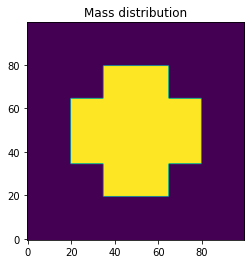

In [3]:
# mass
mass = np.zeros((extent, extent))

# define a planet
planet = 30
#add_round_mass(mass, centre, centre, planet)
add_square_mass(mass, centre, centre - planet // 2, planet // 2)
add_square_mass(mass, centre, centre + planet // 2, planet // 2)
add_square_mass(mass, centre - planet // 2, centre, planet // 2)
add_square_mass(mass, centre + planet // 2, centre, planet // 2)

plt.imshow(mass, origin='lower')
plt.title('Mass distribution')
plt.show()

# Determine a curve that follows the surface

Find the next cell forward, and to the side, given a direction, for determining contact with mass

In [4]:
def forward(i, j, dir):
  sign = 1 if dir >= 2 else -1
  di = (dir % 2 == 0) * sign
  dj = (dir % 2 == 1) * -sign
  return i + di, j + dj

def contact(i, j, dir):
  return forward(i, j, (dir + 1) % 4)

Follow the surface of the mass (LH/RH maze algorithm). Todo - tidy this up a bit as a method

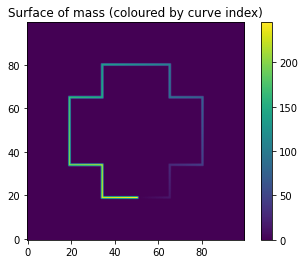

In [5]:
# find min centre
i0 = 0
j0 = centre
while mass[i0 + 1, j0] == 0:
  i0 = i0 + 1

# start surface curve
sc = ([i0], [j0])

# set direction & first point
dir = 1
i = i0
j = j0 + 1
sc[0].append(i)
sc[1].append(j)

# trace edge of mass with right-hand maze following
while not (i == i0 and j == j0):
  check_contact = contact(i, j, dir)
  if mass[check_contact[0], check_contact[1]] == 0:
    dir = (dir + 1) % 4
  check_forward = forward(i, j, dir)
  while mass[check_forward[0], check_forward[1]] != 0:
    dir = (dir + 3) % 4
    check_forward = forward(i, j, dir)
  sc[0].append(check_forward[0])
  sc[1].append(check_forward[1])
  i = check_forward[0]
  j = check_forward[1]

# visualise surface curve
sc_seq = np.linspace(0, len(sc[0]), len(sc[0]))
surf = np.zeros((extent, extent))
surf[sc] = sc_seq

plt.imshow(surf, origin='lower')
plt.title('Surface of mass (coloured by curve index)')
plt.colorbar()
plt.show()

# Calculate Gravity

All points in this indexed region that have mass (currently assumed unit mass - todo repeated points could increase density)

In [6]:
pmg = np.argwhere(mass > 0)
pmg.shape

(2700, 2)

Meshgrid for all indexed points in space to feel all points with mass

In [7]:
mi = np.arange(len(pmg))
nj = np.arange(len(png))
mig, njg = np.meshgrid(mi, nj)
pmg[mig].shape, png[njg].shape

((10000, 2700, 2), (10000, 2700, 2))

Contribution to gravitational field from at a point from a mass - need to move mass to centre of cell

In [8]:
def dgrav(pm, pn):
  d = pm + [0.5, 0.5] - pn
  r = np.hypot(d[:,:,0], d[:,:,1])
  return d / np.power(r, 3).reshape(png.shape[0], pmg.shape[0], 1)

Gravitational field regional calculation

In [9]:
G = np.apply_along_axis(sum, 1, dgrav(pmg[mig], png[njg]))

Resultant field outside of masses

In [10]:
G_grid = G.reshape((extent, extent, 2))
G_grid[np.nonzero(mass)] = 0

# Visualise field in space and on surface

Visualise field strength in space and along surface

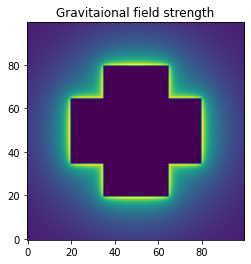

In [24]:
field_strength = np.hypot(G_grid[:,:,1], G_grid[:,:,0])
plt.imshow(field_strength, origin='lower')
plt.title('Gravitaional field strength')
plt.show()

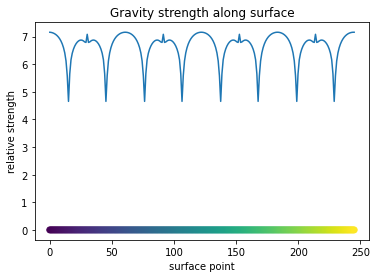

In [23]:
f = field_strength[sc]

plt.plot(sc_seq, f)
plt.scatter(sc_seq, np.zeros(sc_seq.shape[0]), c=sc_seq)
plt.title('Gravity strength along surface')
plt.xlabel('surface point')
plt.ylabel('relative strength')
plt.ylim((0 - max(f) * 0.05, max(f) * 1.05))
plt.show()

Visualise field direction in space and along surface

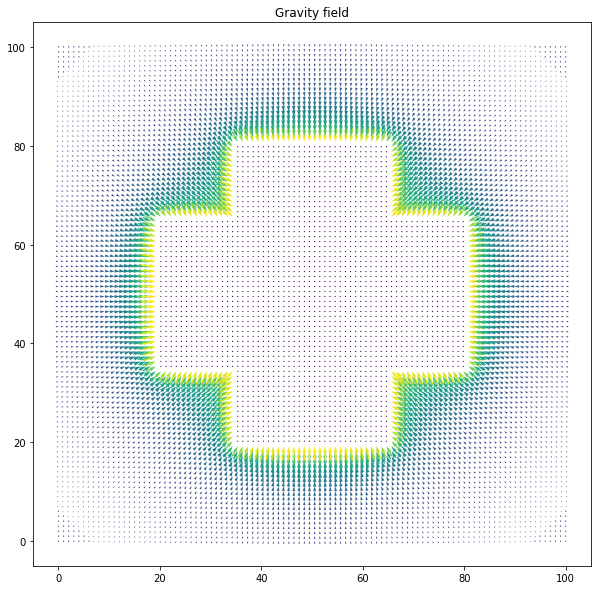

In [13]:
G_lin = G_grid.reshape((extent * extent, 2))

colours = np.hypot(G_lin[:,0], G_lin[:,1])
plt.figure(figsize=(10, 10))
plt.quiver(xng, yng, G_lin[:,0], G_lin[:,1], colours, pivot='tip')
plt.title('Gravity field')
plt.show()

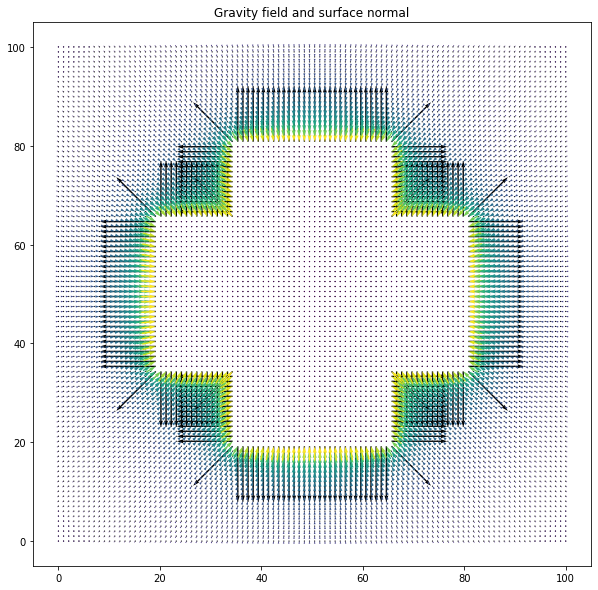

In [14]:
# get surface normal
sc_prev = np.roll(sc, -1, 1)
sc_next = np.roll(sc, 1, 1)
sc_dir = sc_next - sc_prev
sc_len = np.hypot(sc_dir[0,:], sc_dir[1,:])
sc_tan = sc_dir / sc_len
# coords a bit hacky here... 0 & 1 should be reversed
sc_norm = np.array((-sc_tan[0,:], sc_tan[1,:]))

N_grid = np.zeros((extent, extent, 2))
N_grid[sc] = sc_norm.T
N_lin = N_grid.reshape((extent * extent), 2)

plt.figure(figsize=(10, 10))
plt.quiver(xng, yng, N_lin[:,0], N_lin[:,1], pivot='tail', scale=10)
plt.quiver(xng, yng, G_lin[:,0], G_lin[:,1], colours, pivot='tip')
plt.title("Gravity field and surface normal")
plt.show()

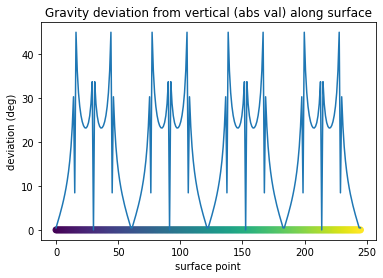

In [15]:
G_sc = G_grid[sc].T
G_sc_norm = G_sc / f

# is there an easier way to do this??
inner_prod = G_sc_norm[0,:] * sc_norm[0,:] + G_sc_norm[1,:] * sc_norm[1,:]
a = 180 / math.pi * np.arccos(-inner_prod)

plt.plot(sc_seq, a)
plt.scatter(sc_seq, np.zeros(sc_seq.shape[0]), c=sc_seq)
plt.title('Gravity deviation from vertical (abs val) along surface')
plt.xlabel('surface point')
plt.ylabel('deviation (deg)')
plt.show()

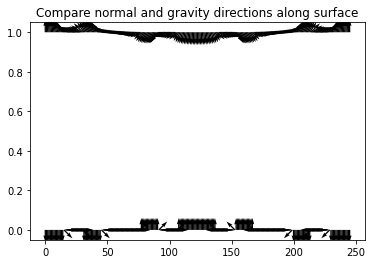

In [16]:
plt.quiver(sc_seq, np.zeros(sc_seq.shape[0]), sc_norm[0,:], sc_norm[1,:], pivot='tail')
plt.quiver(sc_seq, np.ones(sc_seq.shape[0]), G_sc[0,:], G_sc[1,:], pivot='tail')
plt.title('Compare normal and gravity directions along surface')
plt.show()

# Unused edge detection techniques

May be useful in other scenarios...

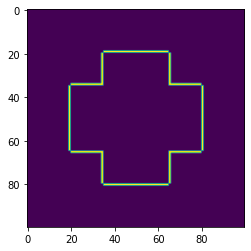

In [17]:
# edge detection binary 4-way

mass_left = np.roll(mass, 1, 0)
mass_right = np.roll(mass, -1, 0)
mass_up = np.roll(mass, 1, 1)
mass_down = np.roll(mass, -1, 1)
surf = ((mass_left - mass) > 0) | ((mass_right - mass) > 0) | ((mass_up - mass) > 0) | ((mass_down - mass) > 0)
plt.imshow(surf)
plt.show()

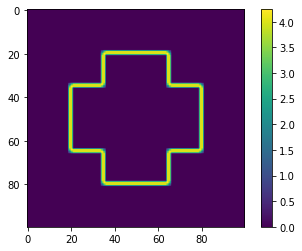

In [18]:
# generic edge detect

from scipy import ndimage

sx = ndimage.sobel(mass, axis=0, mode='constant')
sy = ndimage.sobel(mass, axis=1, mode='constant')
sob = np.hypot(sx, sy)
plt.imshow(sob)
plt.colorbar()
plt.show()